In [2]:
import math
import numpy as np
import skimage.draw
import scipy
from scipy.stats import poisson
from scipy.stats import uniform
import matplotlib.pyplot as plt
from matplotlib import cm
from numba import cuda
from numba.types import int32
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32, xoroshiro128p_uniform_float64, \
    xoroshiro128p_normal_float32, xoroshiro128p_normal_float64
import uproot
import time
from skimage.feature.peak import peak_local_max
import cupy as cp

In [51]:
nwires = 1664  # Number of TPC wires (dimension along the beam)
nticks = 3400  # Number of TPC time ticks (dimension transverse to the beam)
noise_mu = 0  # Noise amplitude [# electrons]
noise_std = 250  # Noise standard deviation [# electrons]
signal_q = 0.075  # Signal charge [units of e]
# somewhere between 0.05 and 0.045, goes from being able to usually find both to being able to only find one
# finds average of 1.5 lines with q=0.049
# signal_q = 0.049  # Signal charge [units of e]
# signal_q = 0.002  # Signal charge [units of e]

# Constants used to calculate paths that point back to target
target = -11000  # Distance to target [cm]
dwire = 0.3  # Distance between wires [cm]
dtick = 0.05  # Distance between ticks [cm]
max = 1  # Upper y limit
min = -1  # Lower y limit

In [15]:
event = noise.T

In [59]:
# Random noise and an empty signal to start with
# event = np.random.normal(noise_mu, noise_std, size=nticks * nwires).reshape((nticks, nwires))
# event = np.zeros((nticks, nwires))
# print("event.shape = ", event.shape)
# event = noise.T.copy()
print("event.shape = ", event.shape)

# Lines approximating track(s)
ntracks = 2
# truth = np.empty(shape=(ntracks, 2), dtype=float)
truth = np.array([[2338, 1574], [2721, 2109]])

# Very approximate scale factor for converting signal amplitude to # electrons
# sf = 1e6 / 23.6 / 10 * signal_q ** 2
sf = 1.5
print("sf = ", sf)
print("2.1 * sf = ", 2.1 * sf)
print("0.15 * sf = ", 0.15 * sf)

# for i in range(ntracks):
#     # start_y, end_y = np.random.randint(0, nticks - 1, size=2)  # Start/end points
#     # start_y, end_y = 100 * i, 100 * i  # Start/end points
#     # truth[i] = [start_y, end_y]  # Keep track of the true start/ends
#     start_y, end_y = truth[i]
#
#     rr, cc, val = skimage.draw.line_aa(start_y - 1, 0, end_y - 1, nwires - 1)  # Fuzzy line
#     line = event[rr, cc]  # All pixels along the line
#
#     signal = np.zeros_like(event)
#     signal[rr, cc] = scipy.stats.moyal.rvs(size=len(line), loc=2.1 * sf, scale=0.15 * sf)  # Signal with fluctuations
#
#     event += signal  # Add this track to the background noise

event.shape =  (3400, 1664)
sf =  1.5
2.1 * sf =  3.1500000000000004
0.15 * sf =  0.22499999999999998


In [4]:
# saving these cuz I'm using for the presentation
truth = np.array([[2338., 1574.], [2721., 2109.]])

In [ ]:
tree = uproot.open('data/noise/millicharged_0.1.root')['millichargedExporter']

In [149]:
ntracks = 1
event_id = 1
digits = tree[f'digits_event{event_id}_plane5']
truth_points = tree[f'truth_{event_id}']

event = digits.to_numpy()[0].T
event = np.ascontiguousarray(event)
nticks, nwires = event.shape

truth_data = np.transpose([truth_points[key].array(library='np') for key in ['wire', 'tick']])
# truth_data[:, 1] -= 737 # constant offset
truth = np.array([[truth_data[0, 1], truth_data[-1, 1]]])
truth

NameError: name 'tree' is not defined

In [41]:
np.log(np.abs(event))

array([[-1.73094875, -0.70570992,  0.96562722, ...,  0.5589921 ,
        -0.89874615, -0.2459618 ],
       [ 0.17547839,  0.10200814, -0.25128097, ...,  0.55482503,
         0.02338068,  0.75594031],
       [-0.04765175, -0.20332447,  0.03222308, ..., -0.6110743 ,
        -0.04156578,  0.02905244],
       ...,
       [-0.62808742,  0.26502656, -0.40799866, ..., -0.91859539,
        -1.46991537, -0.05397524],
       [-0.33259145, -0.55649356, -1.19834696, ..., -1.40600538,
        -1.12401059, -0.52358653],
       [-0.28199917,  0.35091177,  0.39142744, ..., -0.78268773,
        -2.37178405, -1.12141329]])

In [4]:
def downsample(event: np.ndarray, factor: int = 4, downsample: bool = True):
    if downsample:
        shape = event.shape
        downsampled = np.empty((shape[0] // factor, shape[1]))
        for (i, row) in enumerate(downsampled):
            downsampled[i] = np.sum(np.array([event[factor * i + j] for j in range(0, factor)]), axis=0)
        return downsampled
    else:
        return event.copy()

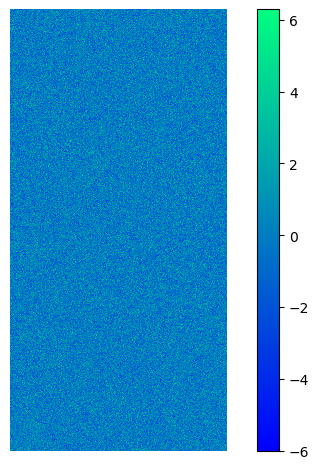

In [60]:
fig, ax = plt.subplots()
# im = ax.imshow(scipy.ndimage.zoom(event, (1, 4)), interpolation='none', cmap='winter')
# im = ax.imshow(event, interpolation='none', cmap=cm.gray)
downsampled = downsample(event, downsample=False)
im = ax.imshow(downsampled, interpolation='none', cmap='winter')
# ax.set_xlabel('Wire')
# ax.set_ylabel('Tick')
plt.colorbar(im)
plt.axis('off')
plt.tight_layout()
plt.savefig('fake_mcp.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

In [54]:
# implementation from paper cited in `skimage.draw.line_aa`:
# Listing 16 of http://members.chello.at/easyfilter/Bresenham.pdf
@cuda.jit(device=True)
def sum_along_line(x0, y0, x1, y1, event, aa, normalize):
    sum = 0
    npoints = 0
    dx = abs(x1 - x0)
    sx = 1 if x0 < x1 else -1
    dy = abs(y1 - y0)
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    ed = 1 if dx + dy == 0 else math.sqrt(dx ** 2 + dy ** 2)
    while True:
        # img[x0, y0] = 255 * (1 - abs(err - dx + dy) / ed)
        # 1 if aa is False, if aa is True (= 1) then subtract the antialiasing amount (multiplication should be faster than branching esp on GPU)
        aa_mult = 1 - aa * abs(err - dx + dy) / ed
        sum += aa_mult * event[x0, y0]
        npoints += aa_mult
        e2 = err
        x2 = x0
        if 2 * e2 >= -dx:
            if x0 == x1:
                break
            if e2 + dy < ed:
                # img[x0, y0 + sy] = 255 * (1 - (e2 + dy) / ed)
                aa_mult = 1 - aa * (e2 + dy) / ed
                sum += aa_mult * event[x0, y0 + sy]
                npoints += aa_mult
            err -= dy
            x0 += sx
        if 2 * e2 <= dy:
            if y0 == y1:
                break
            if dx - e2 < ed:
                # img[x2 + sx, y0] = 255 * (1 - (dx - e2) / ed)
                aa_mult = 1 - aa * (dx - e2) / ed
                sum += aa_mult * event[x2 + sy, y0]
                npoints += aa_mult
            err += dx
            y0 += sy
    return sum / npoints if normalize else sum


@cuda.jit
def make_tracks_gpu(nticks, event, sums, aa, normalize):
    idx1, idx2 = cuda.grid(2)
    if idx1 < nticks and idx2 < nticks:

        slope = ((idx2 - idx1) * dtick) / (nwires * dwire)
        ypos = (slope * target) + (idx1 * dtick)

        if False:
            # if ypos > max or ypos < min:
            sums[idx1, idx2] = -1
        else:
            sums[idx1, idx2] = sum_along_line(idx1, 0, idx2, nwires - 1, event, aa, normalize)


def track_sums(event: np.ndarray, aa=False, normalize=True) -> np.ndarray:
    nticks = event.shape[0]
    print("nticks = ", nticks)
    start_gpu = time.time()
    d_sums = cuda.to_device(np.zeros((nticks, nticks)))
    d_event = cuda.to_device(event)
    n_threads = 32
    tbp = (n_threads, n_threads)
    blocks = tuple(1 + math.ceil(nticks / n_threads) for i in (1, 2))
    make_tracks_gpu[blocks, tbp](nticks, d_event, d_sums, aa, normalize)
    elapsed_gpu = time.time() - start_gpu
    print("gpu time =", elapsed_gpu)
    return d_sums.copy_to_host()

transposing
event.shape =  (3400, 1664)
nticks =  3400
gpu time = 0.05442094802856445
True start/end points:
[[2338 1574]
 [2721 2109]]
Found peaks (local max):
[[ 777 1290]]


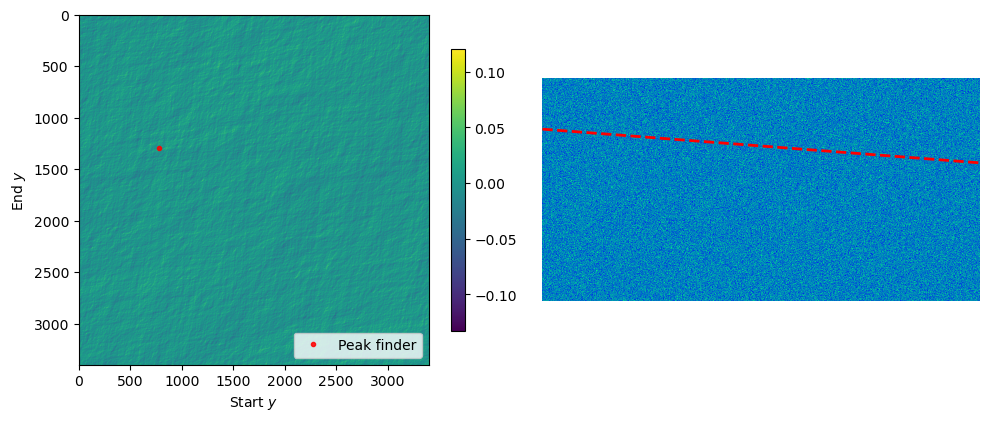

In [91]:
if event.shape == (nwires, nticks):
    print("transposing")
    event = event.T
print("event.shape = ", event.shape)
sums = track_sums(event, aa=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

### Draw the 2D plot
im0 = ax[0].imshow(sums.T)
# ax[0].plot(*list(truth.T), 'o', c='blue', alpha=0.75, label='Truth')
plt.colorbar(im0, shrink=0.6, ax=ax[0])

# Also print out the start/end of true tracks
print('True start/end points:')
print(truth)

### Find peaks in 2D using various scikit-image tools

# Blob finder (disables as it sometimes finds LOTS of blobs)
#peaks = blob_log(h, min_sigma=2, max_sigma=2, num_sigma=2, threshold=0.1)
#peaks = peaks[:,:2]
#ax[0].plot(*list(peaks.T), 'o', c='green', alpha=0.75, label='Blob finder')
#print('Found peaks (blob):')
#print(peaks)

# Local peak finder (given true number of tracks!)
peaks2 = peak_local_max(sums, min_distance=1, num_peaks=1)
ax[0].plot(*list(peaks2.T), '.', c='red', alpha=0.85, label='Peak finder')
print('Found peaks (local max):')
print(peaks2)

ax[0].set_xlabel('Start $y$')
ax[0].set_ylabel('End $y$')
ax[0].legend(loc='lower right')

### Draw the true and found lines
# downsampled = np.empty((event.shape[0] // 4, event.shape[1]))
# for (i, row) in enumerate(downsampled):
#     downsampled[i] = np.sum(np.array([event[4 * i + j] for j in range(0, 4)]), axis=0)
downsampled = downsample(event, downsample=True)
im1 = ax[1].imshow(downsampled, interpolation='none', cmap='winter')

# plt.colorbar(im1, shrink=0.6, ax=ax[1])

# Truth, shifted vertically a bit
# for i, (s, e) in enumerate(truth):
#     ax[1].axline((0, s / 4), (nwires - 1, e / 4), ls='--', c='blue', lw=2, label='Truth')

# Found, shifted vertically a bit
for i, (s, e) in enumerate(peaks2):
    ax[1].axline((0, s / 4), (nwires - 1, e / 4), ls='--', c='red', lw=2, label='Peak finder')

ax[1].set_xlabel('Wire')
ax[1].set_ylabel('Tick')
# ax[1].set_xlim(0, nwires)
# ax[1].set_ylim(0, nticks)
ax[1].axis('off')

plt.tight_layout()
plt.savefig('trk_mcp.png', dpi=500)
plt.show()

In [1]:
# taken from `standard_detsim_sbnd.fcl`
noise_model = {
    "CohExpNorm": 3.67206,
    "CohExpOffset": 2.32098e-1,
    "CohExpWidth": 3.39581,
    "CohGausMean": [
        3.55622e1,
        6.63823e-2,
        1.162e2,
        1.739e2,
        2.898e2
    ],
    "CohGausNorm": [
        6.88535,
        5.21692e-1,
        2.00001,
        2.0363,
        2.00003
    ],
    "CohGausSigma": [
        1.75992e1,
        3.16607e2,
        3.68024e-1,
        3.26335e-1,
        5.1472e-2
    ],
    "CohNoiseArrayPoints": 1000,
    "EffectiveNBits": 1.06e1,
    "EnableCoherentNoise": False,
    "EnableGaussianNoise": False,
    "EnableMicroBooNoise": True,
    "EnableWhiteNoise": False,
    "GausMeanU": [
        630,
        640,
        730
    ],
    "GausMeanV": [
        130,
        330,
        430
    ],
    "GausMeanZ": [
        34
    ],
    "GausNormU": [
        30,
        -3,
        15
    ],
    "GausNormV": [
        30,
        40,
        15
    ],
    "GausNormZ": [
        3
    ],
    "GausSigmaU": [
        5e-1,
        5e-1,
        5e-1
    ],
    "GausSigmaV": [
        5e-1,
        2,
        5e-1
    ],
    "GausSigmaZ": [
        5
    ],
    "IncludeJumpers": False,
    "JumperCapacitance": 5,
    "LogLevel": 0,
    "NChannelsPerCoherentGroup": [
        40,
        40,
        48
    ],
    "NoiseArrayPoints": 1000,
    "NoiseFunctionParameters": [
        1.19777e1,
        170000.0,
        4.93692e3,
        1.03438e3,
        2.33306e2,
        1.36605,
        4.08741,
        3.5e-3,
        9596.0
    ],
    "UFirstJumper": 420,
    "ULastJumper": 1568,
    "VFirstJumper": 417,
    "VLastJumper": 1565,
    "WhiteNoiseU": 1.6,
    "WhiteNoiseV": 1.6,
    "WhiteNoiseZ": 1.6,
    "service_provider": "SBNDuBooNEDataDrivenNoiseService"
}

In [65]:
@cuda.jit(device=True)
def poisson_random2(rng, id, lam):
    u = xoroshiro128p_uniform_float32(rng, id)
    return poisson_random(u, lam)


@cuda.jit(device=True)
def poisson_random(random_number, lam):
    x = 0
    s = p = math.exp(-lam)
    while random_number > s:
        x += 1
        p *= lam / x
        s += p
    return x


@cuda.jit
def poisson_rvs(rng, lam, out):
    id = cuda.grid(1)
    out[id] = poisson_random2(rng, id, lam)


@cuda.jit
def poisson_rvs_2d(rng, lam, out):
    startx, starty = cuda.grid(2)
    stridex, stridey = cuda.gridsize(2)
    id = starty * stridex + startx
    for i in range(starty, out.shape[0], stridey):
        for j in range(startx, out.shape[1], stridex):
            out[i, j] = poisson_random2(rng, id, lam)

In [84]:
@cuda.jit(device=True)
def pfn_f1_gpu2(x, args):
    # args = args[0]
    term1 = args[0] * 1 / (x / 1000 * args[8] / 2)
    term2 = args[1] * math.e ** (-0.5 * (((x / 1000 * args[8] / 2) - args[2]) / args[3]) ** 2)
    term3 = math.e ** (-0.5 * pow(x / 1000 * args[8] / (2 * args[4]), args[5]))
    return (term1 + (term2 * term3) * args[6]) + args[7]


@cuda.jit(device=True)
def calc_noise_frequency_along_wire(tick, noise_params, poisson_number, uniform_number):
    pfnf1val = pfn_f1_gpu2((tick + 0.5) * binwidth, noise_params)
    randomizer = poisson_number
    pval = pfnf1val * randomizer
    phase = uniform_number
    return complex(pval * math.cos(phase), pval * math.sin(phase))


@cuda.jit
def calc_noise_frequencies(rng, lam, noise_params, noise):
    idw, idt = cuda.grid(2)
    sw, st = cuda.gridsize(2)
    id = idw + sw * idt
    for w in range(idw, noise.shape[0], sw):
        for t in range(idt, noise.shape[1], st):
            poisson_number = poisson_random(xoroshiro128p_uniform_float32(rng, id), lam) / lam
            uniform_number = 2 * math.pi * xoroshiro128p_uniform_float32(rng, id)
            noise[w, t] = calc_noise_frequency_along_wire(t, noise_params, poisson_number, uniform_number)


def wld(x):
    return 0.395 + 0.001304 * x


# Drift is 1.3 ms (2600 ticks), and we save 0.20 ms (400 ticks) of pre- and post-drift
number_time_samples = 3400

# sigs = np.zeros(nwires, dtype=float)
# ntick = 4096 # where did 4096 come frome? seems like nowhere
ntick = number_time_samples * 2
# samplerate = 500
clock_freq = 1e9
samplerate = 1000 * (1 / clock_freq)
# from print out sbndcode values
wirelength = 400
# wirelength = 2 * halfLength
binwidth = 1 / (ntick * samplerate * 1e-6)
poisson_mu = 3.30762
noise_model['NoiseFunctionParameters'][6] = wld(wirelength)

bx, by = 8, 8
gx, gy = 16, 16


def gen_noise():
    start = time.time()
    rng_states = create_xoroshiro128p_states(bx * by * gx * gy, seed=1)
    # noise_function_params_d = cuda.to_device(noise_model['NoiseFunctionParameters'])
    noise_function_params_d = cp.array(noise_model['NoiseFunctionParameters'])
    # noise_d = cuda.device_array((nwires, nticks), dtype=complex)
    noise_d = cp.empty((nwires, nticks), dtype=complex)
    calc_noise_frequencies[(gx, gy), (bx, by)](rng_states, poisson_mu, noise_function_params_d, noise_d)
    # kinda magic constant, but basically chosen to take the range to ±6 ADCs
    # todo figure out what the conversion should actually be
    noise_d *= 25000
    print("gen random numbers: ", time.time() - start)

    # print(cp.asarray(noise_d[0]))
    start = time.time()
    noise = np.array([cp.real(cp.fft.ifft(channel_freqs)).get() for channel_freqs in noise_d])
    print("ifft: ", time.time() - start)
    return noise


start = time.time()
for i in range(10):
    noise = gen_noise()
print("elapsed = ", (time.time() - start) / 10)

gen random numbers:  0.5547657012939453
ifft:  0.19275760650634766
gen random numbers:  0.004215240478515625
ifft:  0.1922931671142578
gen random numbers:  0.0043981075286865234
ifft:  0.1881561279296875
gen random numbers:  0.004179954528808594
ifft:  0.19036197662353516
gen random numbers:  0.004529237747192383
ifft:  0.1874070167541504
gen random numbers:  0.00444793701171875
ifft:  0.18461942672729492
gen random numbers:  0.00441431999206543
ifft:  0.18436551094055176
gen random numbers:  0.004059553146362305
ifft:  0.18512821197509766
gen random numbers:  0.004403352737426758
ifft:  0.18352317810058594
gen random numbers:  0.004044055938720703
ifft:  0.18480491638183594
elapsed =  0.24748482704162597


np.min(noise) =  -6.027476311511383
np.max(noise) =  6.297915262907739


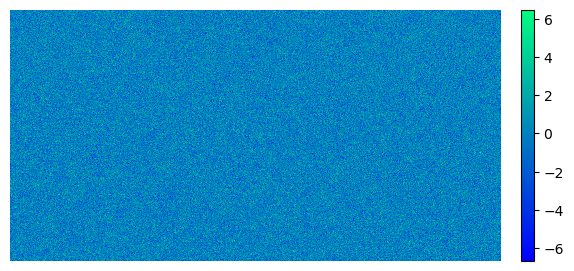

In [67]:
fig, ax = plt.subplots()
downsampled = downsample(noise.T, downsample=True) / 1.8
im = ax.imshow(downsampled, interpolation='none', cmap='winter')
ax.set_xlabel('Wire')
ax.set_ylabel('Tick')
plt.colorbar(im,fraction=0.024, pad=0.04)
plt.tight_layout()
plt.axis('off')
plt.savefig('noise.png', bbox_inches='tight', pad_inches=0, dpi=700)
print("np.min(noise) = ", np.min(noise))
print("np.max(noise) = ", np.max(noise))
plt.show()

In [68]:
# Landau functions

# @formatter:off
p1 = cp.array([0.4259894875, -0.1249762550, 0.03984243700, -0.006298287635,   0.001511162253])
q1 = cp.array([1.0         , -0.3388260629, 0.09594393323, -0.01608042283,    0.003778942063])

p2 = cp.array([0.1788541609, 0.1173957403, 0.01488850518, -0.001394989411,   0.0001283617211])
q2 = cp.array([1.0         , 0.7428795082, 0.3153932961,   0.06694219548,    0.008790609714])

p3 = cp.array([0.1788544503, 0.09359161662, 0.006325387654, 0.00006611667319, -0.000002031049101])
q3 = cp.array([1.0         , 0.6097809921, 0.2560616665,   0.04746722384,    0.006957301675])

p4 = cp.array([0.9874054407, 118.6723273,  849.2794360,   -743.7792444,      427.0262186])
q4 = cp.array([1.0         , 106.8615961,  337.6496214,    2016.712389,      1597.063511])

p5 = cp.array([1.003675074,  167.5702434,  4789.711289,    21217.86767,     -22324.94910])
q5 = cp.array([1.0         , 156.9424537,  3745.310488,    9834.698876,      66924.28357])

p6 = cp.array([1.000827619,  664.9143136,  62972.92665,    475554.6998,     -5743609.109])
q6 = cp.array([1.0         , 651.4101098,  56974.73333,    165917.4725,     -2815759.939])

a1 = cp.array([0.04166666667, -0.01996527778, 0.02709538966])
a2 = cp.array([-1.845568670, -4.284640743])
# @formatter:on

@cuda.jit(device=True)
def landau_pdf(x, p1, q1, p2, q2, p3, q3, p4, q4, p5, q5, p6, q6, a1, a2):
    xi = 1.0
    x0 = 0.0

    v = (x - x0) / xi
    if v < -5.5:
        u = math.exp(v + 1)
        if u < 1e-10:
            return 0.0
        ue = math.exp(-1 / u)
        us = math.sqrt(u)
        denlan = 0.3989422803 * (ue / us) * (1 + (a1[0] + (a1[1] + a1[2] * u) * u) * u)
    elif v < -1:
        u = math.exp(-v - 1)
        denlan = math.exp(-u) * math.sqrt(u) \
                 * (p1[0] + (p1[1] + (p1[2] + (p1[3] + p1[4] * v) * v) * v) * v) \
                 / (q1[0] + (q1[1] + (q1[2] + (q1[3] + q1[4] * v) * v) * v) * v)
    elif v < 1:
        denlan = (p2[0] + (p2[1] + (p2[2] + (p2[3] + p2[4] * v) * v) * v) * v) \
                 / (q2[0] + (q2[1] + (q2[2] + (q2[3] + q2[4] * v) * v) * v) * v)
    elif v < 5:
        denlan = (p3[0] + (p3[1] + (p3[2] + (p3[3] + p3[4] * v) * v) * v) * v) \
                 / (q3[0] + (q3[1] + (q3[2] + (q3[3] + q3[4] * v) * v) * v) * v)
    elif v < 12:
        u = 1 / v
        denlan = u * u * (p4[0] + (p4[1] + (p4[2] + (p4[3] + p4[4] * u) * u) * u) * u) \
                 / (q4[0] + (q4[1] + (q4[2] + (q4[3] + q4[4] * u) * u) * u) * u)
    elif v < 50:
        u = 1 / v
        denlan = u * u * (p5[0] + (p5[1] + (p5[2] + (p5[3] + p5[4] * u) * u) * u) * u) \
                 / (q5[0] + (q5[1] + (q5[2] + (q5[3] + q5[4] * u) * u) * u) * u)
    elif v < 300:
        u = 1 / v
        denlan = u * u * (p6[0] + (p6[1] + (p6[2] + (p6[3] + p6[4] * u) * u) * u) * u) \
                 / (q6[0] + (q6[1] + (q6[2] + (q6[3] + q6[4] * u) * u) * u) * u)
    else:
        u = 1 / (v - v * math.log(v) / (v + 1))
        denlan = u * u * (1 + (a2[0] + a2[1] * u) * u)

    return denlan / xi


@cuda.jit
def landau(x, out, mpv, sigma, p1, q1, p2, q2, p3, q3, p4, q4, p5, q5, p6, q6, a1, a2):
    id = cuda.grid(1)
    value = (x[id] - mpv) / sigma
    pdf = landau_pdf(value, p1, q1, p2, q2, p3, q3, p4, q4, p5, q5, p6, q6, a1, a2)
    out[id] = pdf


# def landau(x, out, mpv, sigma):
#     landau_gpu(x, out, mpv, sigma, p1, q1, p2, q2, p3, q3, p4, q4, p5, q5, p6, q6, a1, a2)
#     return out

f = cp.array([
    0, 0, 0, 0, 0, -2.244733,
    -2.204365, -2.168163, -2.135219, -2.104898, -2.076740, -2.050397,
    -2.025605, -2.002150, -1.979866, -1.958612, -1.938275, -1.918760,
    -1.899984, -1.881879, -1.864385, -1.847451, -1.831030, -1.815083,
    -1.799574, -1.784473, -1.769751, -1.755383, -1.741346, -1.727620,
    -1.714187, -1.701029, -1.688130, -1.675477, -1.663057, -1.650858,
    -1.638868, -1.627078, -1.615477, -1.604058, -1.592811, -1.581729,
    -1.570806, -1.560034, -1.549407, -1.538919, -1.528565, -1.518339,
    -1.508237, -1.498254, -1.488386, -1.478628, -1.468976, -1.459428,
    -1.449979, -1.440626, -1.431365, -1.422195, -1.413111, -1.404112,
    -1.395194, -1.386356, -1.377594, -1.368906, -1.360291, -1.351746,
    -1.343269, -1.334859, -1.326512, -1.318229, -1.310006, -1.301843,
    -1.293737, -1.285688, -1.277693, -1.269752, -1.261863, -1.254024,
    -1.246235, -1.238494, -1.230800, -1.223153, -1.215550, -1.207990,
    -1.200474, -1.192999, -1.185566, -1.178172, -1.170817, -1.163500,
    -1.156220, -1.148977, -1.141770, -1.134598, -1.127459, -1.120354,
    -1.113282, -1.106242, -1.099233, -1.092255,
    -1.085306, -1.078388, -1.071498, -1.064636, -1.057802, -1.050996,
    -1.044215, -1.037461, -1.030733, -1.024029, -1.017350, -1.010695,
    -1.004064, -.997456, -.990871, -.984308, -.977767, -.971247,
    -.964749, -.958271, -.951813, -.945375, -.938957, -.932558,
    -.926178, -.919816, -.913472, -.907146, -.900838, -.894547,
    -.888272, -.882014, -.875773, -.869547, -.863337, -.857142,
    -.850963, -.844798, -.838648, -.832512, -.826390, -.820282,
    -.814187, -.808106, -.802038, -.795982, -.789940, -.783909,
    -.777891, -.771884, -.765889, -.759906, -.753934, -.747973,
    -.742023, -.736084, -.730155, -.724237, -.718328, -.712429,
    -.706541, -.700661, -.694791, -.688931, -.683079, -.677236,
    -.671402, -.665576, -.659759, -.653950, -.648149, -.642356,
    -.636570, -.630793, -.625022, -.619259, -.613503, -.607754,
    -.602012, -.596276, -.590548, -.584825, -.579109, -.573399,
    -.567695, -.561997, -.556305, -.550618, -.544937, -.539262,
    -.533592, -.527926, -.522266, -.516611, -.510961, -.505315,
    -.499674, -.494037, -.488405, -.482777,
    -.477153, -.471533, -.465917, -.460305, -.454697, -.449092,
    -.443491, -.437893, -.432299, -.426707, -.421119, -.415534,
    -.409951, -.404372, -.398795, -.393221, -.387649, -.382080,
    -.376513, -.370949, -.365387, -.359826, -.354268, -.348712,
    -.343157, -.337604, -.332053, -.326503, -.320955, -.315408,
    -.309863, -.304318, -.298775, -.293233, -.287692, -.282152,
    -.276613, -.271074, -.265536, -.259999, -.254462, -.248926,
    -.243389, -.237854, -.232318, -.226783, -.221247, -.215712,
    -.210176, -.204641, -.199105, -.193568, -.188032, -.182495,
    -.176957, -.171419, -.165880, -.160341, -.154800, -.149259,
    -.143717, -.138173, -.132629, -.127083, -.121537, -.115989,
    -.110439, -.104889, -.099336, -.093782, -.088227, -.082670,
    -.077111, -.071550, -.065987, -.060423, -.054856, -.049288,
    -.043717, -.038144, -.032569, -.026991, -.021411, -.015828,
    -.010243, -.004656, .000934, .006527, .012123, .017722,
    .023323, .028928, .034535, .040146, .045759, .051376,
    .056997, .062620, .068247, .073877,
    .079511, .085149, .090790, .096435, .102083, .107736,
    .113392, .119052, .124716, .130385, .136057, .141734,
    .147414, .153100, .158789, .164483, .170181, .175884,
    .181592, .187304, .193021, .198743, .204469, .210201,
    .215937, .221678, .227425, .233177, .238933, .244696,
    .250463, .256236, .262014, .267798, .273587, .279382,
    .285183, .290989, .296801, .302619, .308443, .314273,
    .320109, .325951, .331799, .337654, .343515, .349382,
    .355255, .361135, .367022, .372915, .378815, .384721,
    .390634, .396554, .402481, .408415, .414356, .420304,
    .426260, .432222, .438192, .444169, .450153, .456145,
    .462144, .468151, .474166, .480188, .486218, .492256,
    .498302, .504356, .510418, .516488, .522566, .528653,
    .534747, .540850, .546962, .553082, .559210, .565347,
    .571493, .577648, .583811, .589983, .596164, .602355,
    .608554, .614762, .620980, .627207, .633444, .639689,
    .645945, .652210, .658484, .664768,
    .671062, .677366, .683680, .690004, .696338, .702682,
    .709036, .715400, .721775, .728160, .734556, .740963,
    .747379, .753807, .760246, .766695, .773155, .779627,
    .786109, .792603, .799107, .805624, .812151, .818690,
    .825241, .831803, .838377, .844962, .851560, .858170,
    .864791, .871425, .878071, .884729, .891399, .898082,
    .904778, .911486, .918206, .924940, .931686, .938446,
    .945218, .952003, .958802, .965614, .972439, .979278,
    .986130, .992996, .999875, 1.006769, 1.013676, 1.020597,
    1.027533, 1.034482, 1.041446, 1.048424, 1.055417, 1.062424,
    1.069446, 1.076482, 1.083534, 1.090600, 1.097681, 1.104778,
    1.111889, 1.119016, 1.126159, 1.133316, 1.140490, 1.147679,
    1.154884, 1.162105, 1.169342, 1.176595, 1.183864, 1.191149,
    1.198451, 1.205770, 1.213105, 1.220457, 1.227826, 1.235211,
    1.242614, 1.250034, 1.257471, 1.264926, 1.272398, 1.279888,
    1.287395, 1.294921, 1.302464, 1.310026, 1.317605, 1.325203,
    1.332819, 1.340454, 1.348108, 1.355780,
    1.363472, 1.371182, 1.378912, 1.386660, 1.394429, 1.402216,
    1.410024, 1.417851, 1.425698, 1.433565, 1.441453, 1.449360,
    1.457288, 1.465237, 1.473206, 1.481196, 1.489208, 1.497240,
    1.505293, 1.513368, 1.521465, 1.529583, 1.537723, 1.545885,
    1.554068, 1.562275, 1.570503, 1.578754, 1.587028, 1.595325,
    1.603644, 1.611987, 1.620353, 1.628743, 1.637156, 1.645593,
    1.654053, 1.662538, 1.671047, 1.679581, 1.688139, 1.696721,
    1.705329, 1.713961, 1.722619, 1.731303, 1.740011, 1.748746,
    1.757506, 1.766293, 1.775106, 1.783945, 1.792810, 1.801703,
    1.810623, 1.819569, 1.828543, 1.837545, 1.846574, 1.855631,
    1.864717, 1.873830, 1.882972, 1.892143, 1.901343, 1.910572,
    1.919830, 1.929117, 1.938434, 1.947781, 1.957158, 1.966566,
    1.976004, 1.985473, 1.994972, 2.004503, 2.014065, 2.023659,
    2.033285, 2.042943, 2.052633, 2.062355, 2.072110, 2.081899,
    2.091720, 2.101575, 2.111464, 2.121386, 2.131343, 2.141334,
    2.151360, 2.161421, 2.171517, 2.181648, 2.191815, 2.202018,
    2.212257, 2.222533, 2.232845, 2.243195,
    2.253582, 2.264006, 2.274468, 2.284968, 2.295507, 2.306084,
    2.316701, 2.327356, 2.338051, 2.348786, 2.359562, 2.370377,
    2.381234, 2.392131, 2.403070, 2.414051, 2.425073, 2.436138,
    2.447246, 2.458397, 2.469591, 2.480828, 2.492110, 2.503436,
    2.514807, 2.526222, 2.537684, 2.549190, 2.560743, 2.572343,
    2.583989, 2.595682, 2.607423, 2.619212, 2.631050, 2.642936,
    2.654871, 2.666855, 2.678890, 2.690975, 2.703110, 2.715297,
    2.727535, 2.739825, 2.752168, 2.764563, 2.777012, 2.789514,
    2.802070, 2.814681, 2.827347, 2.840069, 2.852846, 2.865680,
    2.878570, 2.891518, 2.904524, 2.917588, 2.930712, 2.943894,
    2.957136, 2.970439, 2.983802, 2.997227, 3.010714, 3.024263,
    3.037875, 3.051551, 3.065290, 3.079095, 3.092965, 3.106900,
    3.120902, 3.134971, 3.149107, 3.163312, 3.177585, 3.191928,
    3.206340, 3.220824, 3.235378, 3.250005, 3.264704, 3.279477,
    3.294323, 3.309244, 3.324240, 3.339312, 3.354461, 3.369687,
    3.384992, 3.400375, 3.415838, 3.431381, 3.447005, 3.462711,
    3.478500, 3.494372, 3.510328, 3.526370,
    3.542497, 3.558711, 3.575012, 3.591402, 3.607881, 3.624450,
    3.641111, 3.657863, 3.674708, 3.691646, 3.708680, 3.725809,
    3.743034, 3.760357, 3.777779, 3.795300, 3.812921, 3.830645,
    3.848470, 3.866400, 3.884434, 3.902574, 3.920821, 3.939176,
    3.957640, 3.976215, 3.994901, 4.013699, 4.032612, 4.051639,
    4.070783, 4.090045, 4.109425, 4.128925, 4.148547, 4.168292,
    4.188160, 4.208154, 4.228275, 4.248524, 4.268903, 4.289413,
    4.310056, 4.330832, 4.351745, 4.372794, 4.393982, 4.415310,
    4.436781, 4.458395, 4.480154, 4.502060, 4.524114, 4.546319,
    4.568676, 4.591187, 4.613854, 4.636678, 4.659662, 4.682807,
    4.706116, 4.729590, 4.753231, 4.777041, 4.801024, 4.825179,
    4.849511, 4.874020, 4.898710, 4.923582, 4.948639, 4.973883,
    4.999316, 5.024942, 5.050761, 5.076778, 5.102993, 5.129411,
    5.156034, 5.182864, 5.209903, 5.237156, 5.264625, 5.292312,
    5.320220, 5.348354, 5.376714, 5.405306, 5.434131, 5.463193,
    5.492496, 5.522042, 5.551836, 5.581880, 5.612178, 5.642734,
    5.673552, 5.704634, 5.735986, 5.767610,
    5.799512, 5.831694, 5.864161, 5.896918, 5.929968, 5.963316,
    5.996967, 6.030925, 6.065194, 6.099780, 6.134687, 6.169921,
    6.205486, 6.241387, 6.277630, 6.314220, 6.351163, 6.388465,
    6.426130, 6.464166, 6.502578, 6.541371, 6.580553, 6.620130,
    6.660109, 6.700495, 6.741297, 6.782520, 6.824173, 6.866262,
    6.908795, 6.951780, 6.995225, 7.039137, 7.083525, 7.128398,
    7.173764, 7.219632, 7.266011, 7.312910, 7.360339, 7.408308,
    7.456827, 7.505905, 7.555554, 7.605785, 7.656608, 7.708035,
    7.760077, 7.812747, 7.866057, 7.920019, 7.974647, 8.029953,
    8.085952, 8.142657, 8.200083, 8.258245, 8.317158, 8.376837,
    8.437300, 8.498562, 8.560641, 8.623554, 8.687319, 8.751955,
    8.817481, 8.883916, 8.951282, 9.019600, 9.088889, 9.159174,
    9.230477, 9.302822, 9.376233, 9.450735, 9.526355, 9.603118,
    9.681054, 9.760191, 9.840558, 9.922186, 10.005107, 10.089353,
    10.174959, 10.261958, 10.350389, 10.440287, 10.531693, 10.624646,
    10.719188, 10.815362, 10.913214, 11.012789, 11.114137, 11.217307,
    11.322352, 11.429325, 11.538283, 11.649285,
    11.762390, 11.877664, 11.995170, 12.114979, 12.237161, 12.361791,
    12.488946, 12.618708, 12.751161, 12.886394, 13.024498, 13.165570,
    13.309711, 13.457026, 13.607625, 13.761625, 13.919145, 14.080314,
    14.245263, 14.414134, 14.587072, 14.764233, 14.945778, 15.131877,
    15.322712, 15.518470, 15.719353, 15.925570, 16.137345, 16.354912,
    16.578520, 16.808433, 17.044929, 17.288305, 17.538873, 17.796967,
    18.062943, 18.337176, 18.620068, 18.912049, 19.213574, 19.525133,
    19.847249, 20.180480, 20.525429, 20.882738, 21.253102, 21.637266,
    22.036036, 22.450278, 22.880933, 23.329017, 23.795634, 24.281981,
    24.789364, 25.319207, 25.873062, 26.452634, 27.059789, 27.696581,
    28.365274, 29.068370, 29.808638, 30.589157, 31.413354, 32.285060,
    33.208568, 34.188705, 35.230920, 36.341388, 37.527131, 38.796172,
    40.157721, 41.622399, 43.202525, 44.912465, 46.769077, 48.792279,
    51.005773, 53.437996, 56.123356, 59.103894])
assert len(f) == 982


@cuda.jit(device=True)
def landau_quantile(z, xi, f):
    """
    LANDAU quantile : algorithm from CERNLIB G110 ranlan
    with scale parameter xi
    Converted by Rene Brun from CERNLIB routine ranlan(G110),
    Moved and adapted to QuantFuncMathCore by B. List 29.4.2010
    :param xi bust be greater than 1
    :param z must be between 0 and 1, exclusive
    """
    u = 1000 * z
    i = int(u)
    u -= i
    if 70 <= i < 800:
        ranlan = f[i - 1] + u * (f[i] - f[i - 1])
    elif 7 <= i <= 980:
        ranlan = f[i - 1] + u * (f[i] - f[i - 1] - 0.25 * (1 - u) * (f[i + 1] - f[i] - f[i - 1] + f[i - 2]))
    elif i < 7:
        v = math.log(z)
        u = 1 / v
        ranlan = ((0.99858950 + (3.45213058E1 + 1.70854528E1 * u) * u) / (1 + (3.41760202E1 + 4.01244582 * u) * u)) \
                 * (-math.log(-0.91893853 - v) - 1)
    else:
        u = 1 - z
        v = u * u
        if z <= 0.999:
            ranlan = (1.00060006 + 2.63991156E2 * u + 4.37320068E3 * v) / (
                    (1 + 2.57368075E2 * u + 3.41448018E3 * v) * u)
        else:
            ranlan = (1.00001538 + 6.07514119E3 * u + 7.34266409E5 * v) / (
                    (1 + 6.06511919E3 * u + 6.94021044E5 * v) * u)

    return xi * ranlan


@cuda.jit
def landau_rvs(rng, out, mu, sigma, f):
    """
     Generate a random number following a Landau distribution
     with location parameter mu and scale parameter sigma:
          Landau( (x-mu)/sigma )
     Note that mu is not the mpv(most probable value) of the Landa distribution
     and sigma is not the standard deviation of the distribution which is not defined.
     For mu  =0 and sigma=1, the mpv = -0.22278

     The Landau random number generation is implemented using the
     function landau_quantile(x,sigma), which provides
     the inverse of the landau cumulative distribution.
     landau_quantile has been converted from CERNLIB ranlan(G110).
    """
    id = cuda.grid(1)
    x = xoroshiro128p_uniform_float32(rng, id)
    out[id] = mu + landau_quantile(x, sigma, f)

/home/aschwart/anaconda3/envs/mq/lib/python3.10/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0.311352014541626
len(rands) =  3996


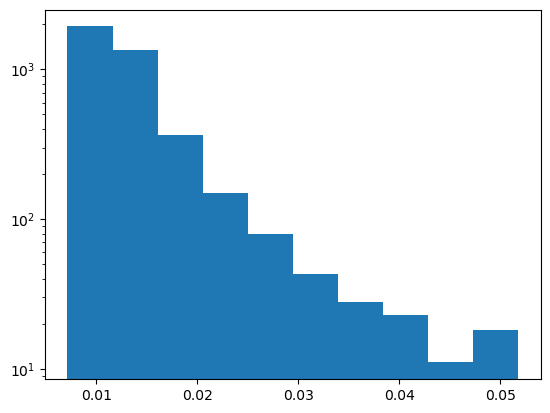

In [69]:
start = time.time()
rng_states = create_xoroshiro128p_states(64 * 64, seed=1)
landau_randoms_d = cp.empty(64 * 64)
landau_rvs[64, 64](rng_states, landau_randoms_d, dEdx_mean, dEdx_mean / width_factor, f)
print(time.time() - start)

rands = landau_randoms_d[(landau_randoms_d > 0) & (landau_randoms_d < 5 * dEdx_mean)]
# print(np.min(rands))
# rands = landau_randoms_d[(-100 < landau_randoms_d) & (landau_randoms_d < 100)]
print("len(rands) = ", len(rands))
# np.max(landau_randoms_d.get())
plt.hist(rands.get())
plt.yscale('log')
# plt.show()

In [89]:
DL = 3.74  # cm²/s (longitudinal electron diffusion coeff)
DL = DL * 1e-6  # cm²/μs (longitudinal electron diffusion coeff)
v_d = 1.076  # mm/μs (drift velocity)
v_d = v_d * 1e-1  # cm/μs (drift velocity)
sigma_t0_2 = 1.98  # μs² (time width)
E = 273.9  # V/cm (E field)

# from https://lar.bnl.gov/properties/
energy_per_electron = 23.6  # eV/e⁻ pair
# from https://arxiv.org/pdf/1802.08709.pdf or https://arxiv.org/pdf/1804.02583.pdf
electrons_per_adc = 187  # e⁻/ADC
survival_probability = 0.6980  # % (survive recombination)
dEdx_mean = 2.1173  # MeV/cm
# dEdx_mean = dEdx_mean * 1e6 # eV/cm
z = 0.01  # % (mCP charge fraction)
dEdx_mean *= z ** 2  # scale based on charge
print("dEdx_mean = ", dEdx_mean)

width = 200  # cm
height = 400  # cm
length = 500  # cm (beam direction)
length = nwires  # number

dEdx_mean =  0.00021173000000000003


/home/aschwart/anaconda3/envs/mq/lib/python3.10/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


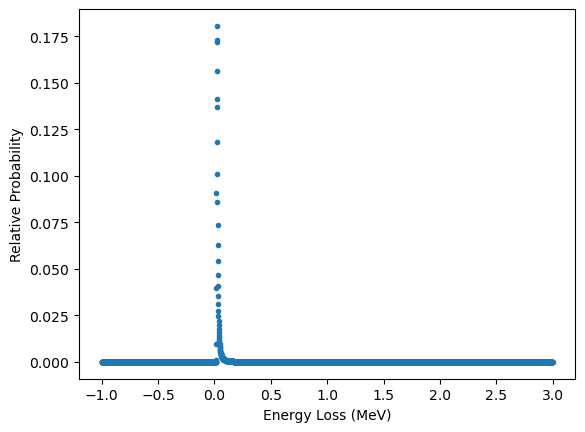

In [75]:
rng_states = create_xoroshiro128p_states(64 * 64, seed=1)
width_factor = 10
x = np.linspace(math.floor(dEdx_mean - 1), math.ceil(dEdx_mean + 2), 64 * 64)
out = np.empty(64 * 64)
landau[64, 64](x, out, dEdx_mean, dEdx_mean / width_factor, p1, q1, p2, q2, p3, q3, p4, q4, p5, q5, p6, q6, a1, a2)
plt.scatter(x, out, marker='.')
plt.xlabel('Energy Loss (MeV)')
plt.ylabel('Relative Probability')
plt.savefig('landau.png', dpi=500)
plt.show()

np.max(energy_losses) =  147908.67420115005
np.min(energy_losses) =  145.7490512390057
x =  [167  52]
y =  [ 43 119]
0
200
400
600
800
1000
1200
1400
1600


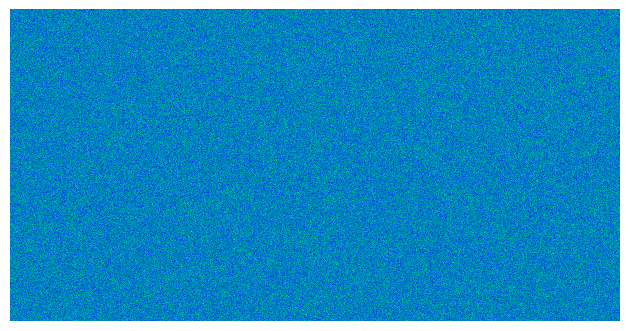

In [90]:
# pre-generate initial energy loss at each point
rng = np.random.default_rng(2)

rng_states = create_xoroshiro128p_states(length + 1, seed=1)
energy_losses_d = cp.empty(length + 1)
threads = 64
blocks = ((length + 1) // 64) + 1
landau_rvs[blocks, threads](rng_states, energy_losses_d, dEdx_mean, dEdx_mean / width_factor, f)
# energy losses in eV
energy_losses = (cp.maximum(1e6 * energy_losses_d, 0)).get()
print("np.max(energy_losses) = ", np.max(energy_losses))
print("np.min(energy_losses) = ", np.min(energy_losses))

# event = np.zeros((1664, 3400))
event = noise.copy()

x, y = [rng.integers(0, max, size=2) for max in [width, height]]
print("x = ", x)
print("y = ", y)
x_start, x_end = x
y_start, y_end = y
x_slope = (x_end - x_start) / length
y_slope = (y_end - y_start) / length

tot_adc = 0
for z in range(0, length + 1, 1):
    x = x_start + x_slope * z
    y = y_start + y_slope * z
    # energy losses in eV
    energy_loss = energy_losses[z]
    if energy_loss == 0:
        continue
    elif energy_loss > 1e5:
        energy_loss = 1e5
    # number of electrons ionized
    ionization_electrons = energy_loss / energy_per_electron
    # number of electrons that make it to readout
    ionization_electrons *= survival_probability

    # drift time in μs
    t = x / v_d
    # print("t = ", t)
    # diffusion radius in cm
    r = math.sqrt(t * DL / math.pi)
    # print("r = ", r)
    # equation 3.1 of https://iopscience.iop.org/article/10.1088/1748-0221/16/09/P09025/pdf
    # this is the width on the collection plane (μs²)
    sigma_t_2 = sigma_t0_2 + (2 * DL / v_d ** 2) * t
    sigma_t = math.sqrt(sigma_t_2)
    sigma_x = sigma_t * v_d * 6  # 10 is fudge factor
    # print("sigma_x = ", sigma_x)
    # print("sigma_x = ", sigma_x)
    # each pair is the offset of 1 adc
    adcs = rng.normal(0, sigma_x, (2, int(ionization_electrons)))
    wires, ticks = adcs
    ticks = ticks / nticks * height
    wires += z
    ticks += y
    ticks = ticks / height * nticks
    # print("adcs = ", adcs)
    # break
    wires, ticks = wires.astype(int), ticks.astype(int)
    # print("wires = ", wires)
    in_bounds = (0 <= wires) & (wires < nwires) & (0 <= ticks) & (ticks < nticks)
    tot_adc += len(in_bounds)
    wires = wires[in_bounds]
    ticks = ticks[in_bounds]
    # print("wires.shape = ", wires.shape)
    # print("ticks.shape = ", ticks.shape)
    wire_min = np.min(wires)
    tick_min = np.min(ticks)
    wire_bins = np.arange(wire_min, np.max(wires) + 1)
    tick_bins = np.arange(tick_min, np.max(ticks) + 1)
    hist, wire_bins, tick_bins = np.histogram2d(wires, ticks, bins=(wire_bins, tick_bins))
    wire_bins = wire_bins[:-1]
    tick_bins = tick_bins[:-1]
    # print("wire_bins = ", wire_bins)
    # print("tick_bins = ", tick_bins)
    # print("wire_bins.shape = ", wire_bins.shape)
    # print("tick_bins.shape = ", tick_bins.shape)
    # print("hist.shape = ", hist.shape)
    # print("hist = ", hist)
    # print("len(tick_bins) = ", len(tick_bins))
    for wb in wire_bins:
        for tb in tick_bins:
            hist_wire = wb - wire_min
            hist_tick = tb - tick_min
            # print("hist[", hist_wire, ",", hist_tick, "] = ", hist[hist_wire, hist_tick])
            event[wb, tb] += hist[hist_wire, hist_tick] / electrons_per_adc
    # for wb, tb in zip(wire_bins[:-1], tick_bins[:-1]):
    #     print("hist[wb, tb - tick_min] = ", hist[wb, tb - tick_min])
    #     event[wb, tb] += hist[wb, tb - tick_min]
    # event[wire_bins, tick_bins] += hist / electrons_per_adc
    # for (w, t) in zip(wires, ticks):
    #     event[w, t] += 1
    # event[wires, ticks] += 1
    if z % 200 == 0:
    #     print("int(ionization_electrons) = ", int(ionization_electrons))
        print(z)

# print("event.sum() = ", event.sum())
# print("tot_adc = ", tot_adc)

plt.imshow(downsample(event.T, downsample=True), interpolation='none', cmap='winter')
# plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.savefig('myevent.png', dpi=700, bbox_inches='tight', pad_inches=0)
plt.show()

In [303]:
np.unique(wires)

array([1659, 1660, 1661, 1662, 1663])

(2, 2957)


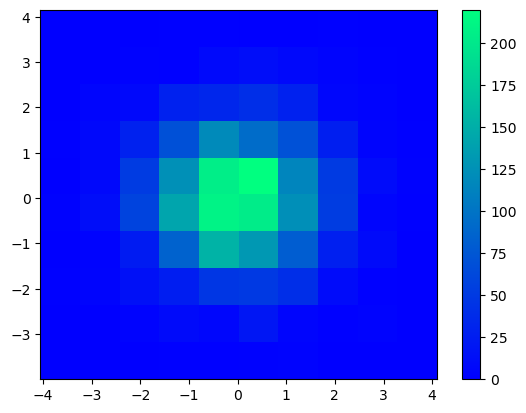

In [33]:
    # test distribution
ionization_electrons = 2957.6271186440677
n_electrons = int(ionization_electrons)
r = 0.04181029892420381
# r=2
sigma_t_2 = 2.9827236425955794
sigma_t = math.sqrt(sigma_t_2)
sigma_x = sigma_t * v_d * 6  # 10 is fudge factor
points = np.random.default_rng().normal(0, sigma_x, (2, n_electrons))
# points = points[:, points[0] ** 2 + points[1] ** 2 <= r ** 2]
print(points.shape)
# points = np.pow(points[0], 2)
# np.histogram2d(points[0], points[1], weights=1/electrons_per_adc)
plt.hist2d(points[0], points[1], cmap='winter')
plt.colorbar()
plt.savefig('diffusion.png', dpi=500)
plt.show()

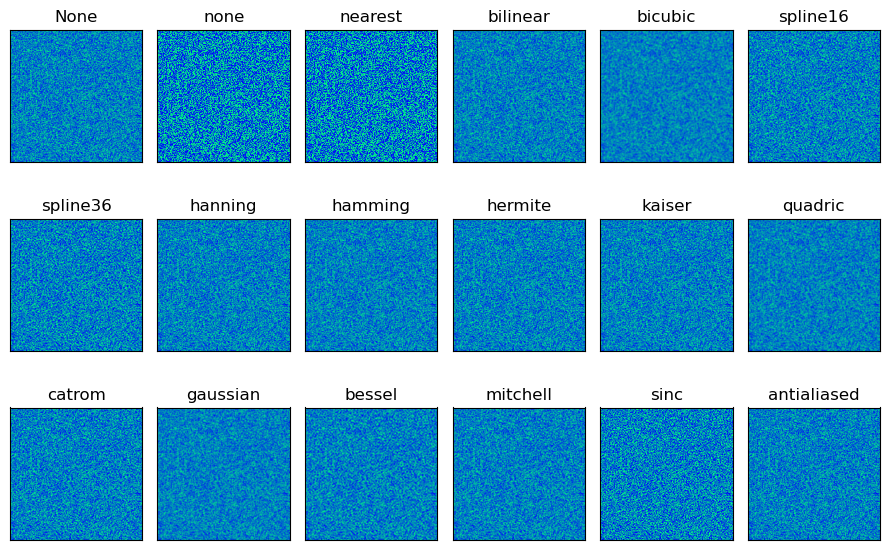

In [51]:
import matplotlib.pyplot as plt
import numpy as np

methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'antialiased']

# Fixing random state for reproducibility
np.random.seed(19680801)

grid = np.random.rand(200, 200)

fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for ax, interp_method in zip(axs.flat, methods):
    ax.imshow(grid, interpolation=interp_method, cmap='winter')
    ax.set_title(str(interp_method))

plt.tight_layout()
plt.show()